I feel that for the market's predictive effect, we need to affect price not dividend? It is so very around-the-corner way of doing things when you let agents trade and a very small effect is by dividend which should be predicted in the end...

### Imports

In [1]:
import cupy as cp
import pandas as pd
import numpy as np
from market_gpu import Market, save_model, read_model, plot_market
import matplotlib.pyplot as plt
#plt.style.use('Solarize_Light2')
from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=True)
%load_ext autoreload
%autoreload 2

## Market GPU

### Time each function

In [ ]:
# import time

# total_refresh, total_transact, total_feedback, total_update_market = 0,0,0,0
# total_mutate = 0
# for _ in range(500):
#     """Note that order TBD"""
#     start = time.time()
#     m._refresh_params() #sets last price
#     total_refresh += time.time() - start
#     start = time.time()
#     m._transact() #sets new price
#     total_transact += time.time() - start
#     start = time.time()
#     m._feedback_strats()
#     total_feedback += time.time() - start
#     start = time.time()
#     m._update_market_state()
#     total_update_market += time.time() - start
#     start = time.time()
#     m._mutate_strats()
#     total_mutate += time.time() - start

# a = np.array([total_refresh, total_transact, total_feedback, total_update_market, total_mutate])
# s = a.sum()
# np.round(a/s,3), s

## Learning to predict binary dividend

In [6]:
strats_per_agent = 50
len_agents_k = 50
len_signals = 121
#action_ratio = 0.025
action_ratio = 0.05

In [8]:
m = Market(len_agents=len_agents_k, dividend_mode='binary')
m.ignore_agents = cp.arange(len_agents_k)
for _ in range(500):
    m.simulate_k_step()
    i, a = np.where(m.strat_strengths[m.ignore_agents, :] < 0.1)
    m.strats[i, a] = cp.random.choice(
        [1, 0, -1],
        size=(len(i), len_signals),
        p=[action_ratio, 1-2*action_ratio, action_ratio]
    )

    m.actions[i, a] = cp.random.choice(
        [1, -1],
        size=(len(i))
    )

## Analysis

In [2]:
m = Market(len_agents=100, strats_per_agent=100)

In [3]:
m.simulate_k_step(1000)

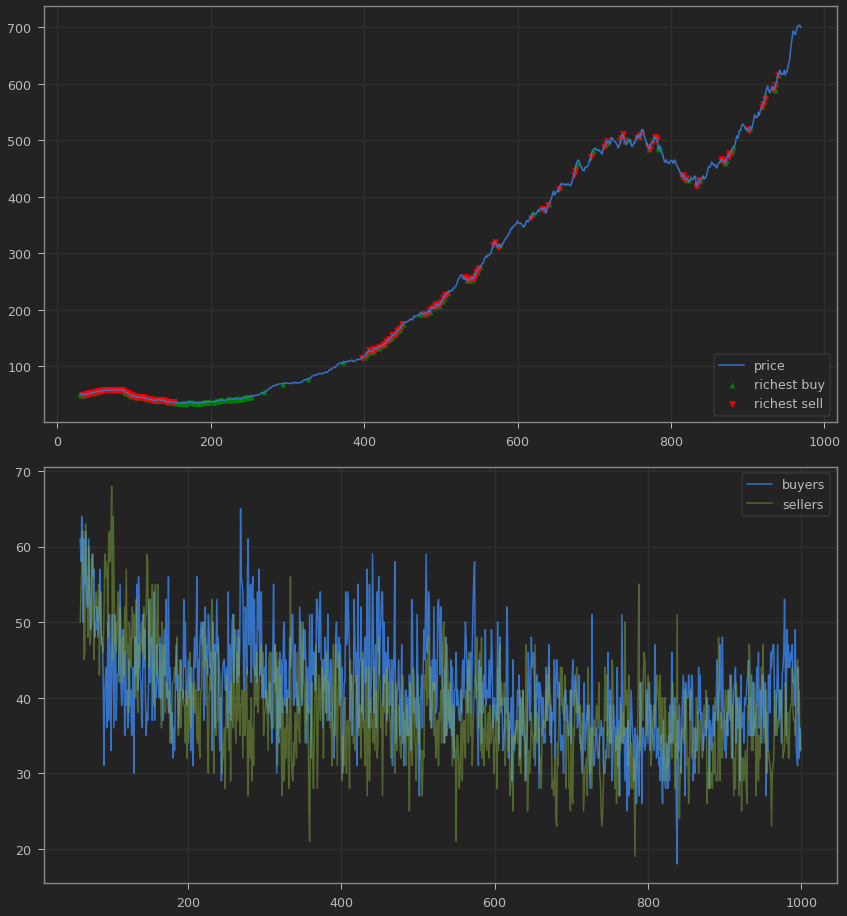

In [5]:
plot_market(m,from_index=0,to_index=940,richest_alpha=1.)

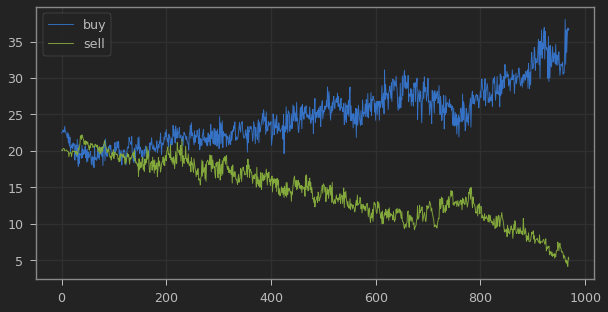

In [6]:
plt.figure(figsize=(10, 5))
plt.plot(m.buy_strs[m.k2:10000], label='buy', linewidth=.9)
plt.plot(m.sell_strs[m.k2:10000], label='sell', linewidth=.9)
plt.legend(loc='best');

## Generative state of the market

### Trying to squeeze out information on what signal is on what index. Broken

In [456]:
means[:-1]/means[1:]

array([1.83834134, 1.59536039, 1.40154044, 1.29195032, 1.22696952])

In [449]:
from market_gpu import create_n_mat

a = np.vstack([(np.array(m.price_history.get())[-m.k2:])]*(m.k2-1)).T
a2 = np.vstack([(np.array(m.volume_history.get())[-m.k2:])]*(m.k2-1)).T
b = np.ma.array(a, mask=create_n_mat(m.k2))[:, ::m.d]  # price_history
c = np.ma.array(a2, mask=create_n_mat(m.k2))[:, ::m.d]  # vol_history
means = np.ma.mean(b, axis=0).data
stdevs = np.ma.std(b, axis=0).data
volmeans = np.ma.mean(c, axis=0).data
mean_signals = np.greater(
    np.vstack([means]*m.k),
    (np.linspace(0.5, 1.5, m.k)*m.price)[:, None]
).flatten('F')
stdev_signals = np.greater(
    np.vstack([stdevs]*m.k),
    (np.linspace(0.001, 1, m.k)*m.price)[:, None]
).flatten('F')
meanvol_signals = np.greater(
    np.vstack([volmeans]*m.k),
    (np.linspace(1, 50, m.k))[:, None]
).flatten('F')
fvals = m.price > np.round(np.linspace(0.25, 4.25, 8), 1)*m.fundamental_value()
rel_means = means[:-1]/means[1:]
#         m.market_state_history.append(m.market_state.get())
m.market_state = cp.array(
    np.r_[mean_signals, stdev_signals, meanvol_signals, fvals, rel_means])

np.vstack([means]*m.k), (np.linspace(0.5, 1.5, m.k)*m.price)[:, None]

(array([[3.08490438e-73, 1.67809117e-73, 1.05185712e-73, 7.50500724e-74,
         5.80905250e-74, 4.73447173e-74],
        [3.08490438e-73, 1.67809117e-73, 1.05185712e-73, 7.50500724e-74,
         5.80905250e-74, 4.73447173e-74],
        [3.08490438e-73, 1.67809117e-73, 1.05185712e-73, 7.50500724e-74,
         5.80905250e-74, 4.73447173e-74],
        [3.08490438e-73, 1.67809117e-73, 1.05185712e-73, 7.50500724e-74,
         5.80905250e-74, 4.73447173e-74],
        [3.08490438e-73, 1.67809117e-73, 1.05185712e-73, 7.50500724e-74,
         5.80905250e-74, 4.73447173e-74],
        [3.08490438e-73, 1.67809117e-73, 1.05185712e-73, 7.50500724e-74,
         5.80905250e-74, 4.73447173e-74]]),
 array([[5.62052424e-78],
        [7.86873394e-78],
        [1.01169436e-77],
        [1.23651533e-77],
        [1.46133630e-77],
        [1.68615727e-77]]))

### Is current market state bullish or bearish?
Let us look at the best performing 50 strats on buy and sell side. Let us sort them so similar strats would be next to each other and plot them. Also see how close the current market state is to the average of best strats. Let this note the faith in the market being bullish or bearish.

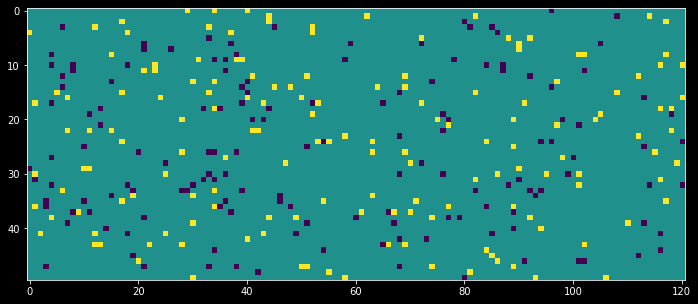

In [6]:
# buys
ia, ist = np.where(m.actions.get() == 1)

strat_strengths = m.strat_strengths[ia, ist].get()
strats = m.strats[ia, ist].get()

i = np.unravel_index(
    strat_strengths.flatten().argsort()[-50:],
    strat_strengths.shape
)

a = strats[i]

# a.sort(axis=0)

plt.figure(figsize=(20, 5))
plt.imshow(a[~np.all(a == 0, axis=1)])

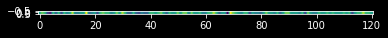

In [7]:
plt.imshow(a[~np.all(a == 0, axis=1)].sum(axis=0)[:, None].T)

In [8]:
# Let this be weights
b = np.maximum(1, np.abs(a[~np.all(a == 0, axis=1)].sum(axis=0)))

np.sum(
    (b/b.max()) *
    (
        m.market_state.get() -
        (1.*(a[~np.all(a == 0, axis=1)].sum(axis=0) > 0) -
         (a[~np.all(a == 0, axis=1)].sum(axis=0) < 0))
    )
)

5.999999999999999

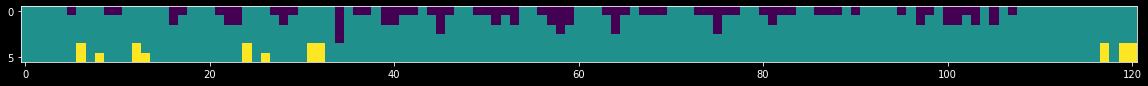

In [9]:
# sells
ia, ist = np.where(m.actions.get() == -1)

strat_strengths = m.strat_strengths[ia, ist].get()
strats = m.strats[ia, ist].get()

i = np.unravel_index(
    strat_strengths.flatten().argsort()[-50:],
    strat_strengths.shape
)

a = strats[i]

a.sort(axis=0)

plt.figure(figsize=(20, 5))
plt.imshow(a[~np.all(a == 0, axis=1)])

In [10]:
# Let this be weights
b = np.maximum(1, np.abs(a[~np.all(a == 0, axis=1)].sum(axis=0)))

np.sum(
    (b/b.max()) *
    (
        m.market_state.get() -
        (1.*(a[~np.all(a == 0, axis=1)].sum(axis=0) > 0) -
         (a[~np.all(a == 0, axis=1)].sum(axis=0) < 0))
    )
)

25.25

### Use best strats to be a "template" of a new strategy

Use some weighted bias towards being more "best strategy"-like. Then replay situations in agent's own "brain" and then discriminate against new strategies. This assumes that agent tends to own strategies that show a full picture of the market, I think, but I hope not.

Also we would need to separate agents that "think" and agents that don't to compare the effect.

## Generalising strats

In [23]:
agent_indeces = cp.arange(m.len_agents)
strat_indeces = m.strat_strengths.argmin(axis=1)
cdf = cp.where(m.strats[agent_indeces, strat_indeces] != 0)
cdf = cp.array([cdf[0], cdf[1]]).T  # ,columns=['strat_ind','strat_cond'])
cp.random.shuffle(cdf)
cdf = cdf[(cdf[:, 0]).argsort()]
si, sb = cdf.T
change_strats = cp.abs(m.strats[agent_indeces, strat_indeces][si]).sum(axis=1)
inv_bools = change_strats < cp.random.choice(
    np.arange(10, 20), size=change_strats.shape[0])
a, b = si[inv_bools], sb[inv_bools]
a2, b2 = si[~inv_bools], sb[~inv_bools]
ag, st = np.where(m.strat_strengths < -0.25)
# m.actions[ag,st] *= -1 #invert superweak strat
# m.strat_strengths[ag,st] *= -1
# m.strats[agent_indeces[a],strat_indeces[b]] *= -1 #mutate
# m.strats[agent_indeces[a2],strat_indeces[b2]] *= 0 #generalise

In [26]:
a

array([  0,   0,   0, ..., 997, 998, 998])

## TODO:

- Dividend as searched function and stability of the result depending on number of agents
- High level communication?
- More continuous signals as market state?
- More stocks?

- Zipfs law implementation? Richest people "reach out" to more other agents. If this fails, then the way to calculate distance has been wrong and needs to be mutated.

## Agents to have different trading frequencies?

Choose some random weights for each agent that determine the trading probability distribution.

In [121]:
m.strats.shape

(1000, 50, 116)

In [ ]:
m.

In [133]:
a = m.strats.get()
s = m.strat_strengths.get()
s = s-s.mean()

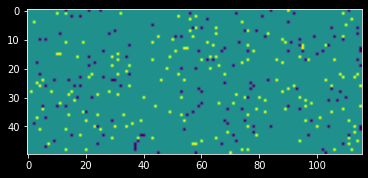

In [129]:
plt.imshow(a[0])

In [210]:
b = np.sort(a[0], axis=0)

In [219]:
b.shape

(50, 116)

In [218]:
b[:, 3]

array([-1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1])

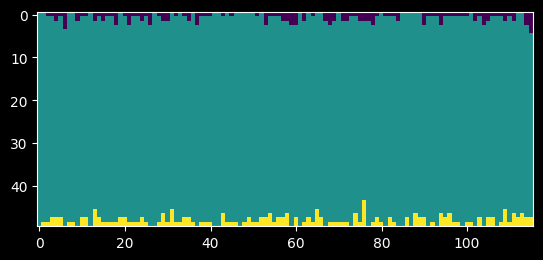

In [209]:
plt.imshow(np.sort(a[0], axis=0))

In [172]:
s.shape

(1000, 50)

In [193]:
im = s[0][:, None]*a[0]
for i in range(1, s.shape[0]):
    im += s[i][:, None]*a[i]*0.1

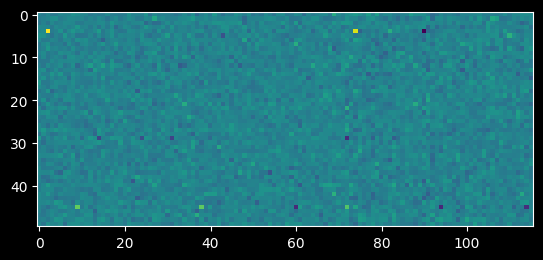

In [207]:
plt.imshow(im)

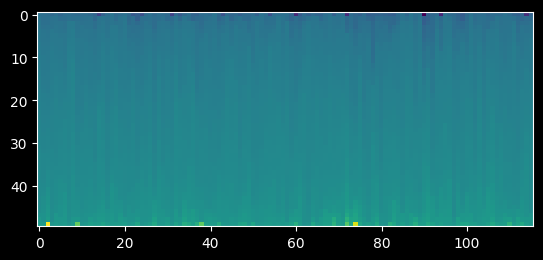

In [208]:
plt.imshow(np.sort(im, axis=0))

## Communication between agents

Groups with 10 agents each communicate their action with their conviction (strength). Discriminate internally against weak decisions. Learnable distance between market states?

In [57]:
m.strat_strengths.shape,m.acting_agent_acts.shape,m.agents_cash.shape

((100, 100), (77,), (100,))

In [7]:
inds,strs = m.acting_agent_strat_tuple
inds.shape, strs.shape

((81,), (81,))

<p style='color:red;'>TODO</p>

Following line outputs:


```array([ 0,  1,  2,  2,  3,  3,  4,  5,  5,  6, 10, 15, 16, 17, 18, 18, 19,
       19, 23, 24, 25, 26, 29, 32, 33, 34, 35, 38, 38, 39, 39, 40, 41, 45,
       45, 46, 47, 48, 49, 50, 51, 52, 53, 56, 57, 58, 58, 62, 62, 67, 68,
       72, 73, 74, 75, 76, 76, 77, 78, 79, 80, 81, 84, 85, 86, 87, 87, 88,
       88, 91, 92, 93, 94, 95, 98, 98, 99])```
       
Something very wrong or just set in the wrong place...

Otherwise get agent indeces < 10 here

In [8]:
inds

array([ 0,  1,  1,  2,  3,  4,  7,  8, 17, 18, 19, 20, 21, 22, 23, 24, 25,
       31, 32, 33, 34, 37, 40, 40, 40, 41, 42, 42, 43, 43, 44, 45, 46, 47,
       48, 49, 50, 51, 54, 54, 54, 57, 60, 61, 62, 62, 63, 63, 64, 65, 65,
       66, 67, 70, 73, 74, 75, 75, 76, 77, 77, 78, 78, 79, 80, 81, 81, 82,
       83, 84, 87, 88, 89, 92, 93, 94, 95, 96, 97, 98, 99])

In [59]:
m.acting_agent_wealth

array([ 3374.36733972, 13737.97408458, 37822.62816401, 37822.62816401,
       39580.08804302, 39580.08804302, 37376.20371376,  3780.83935456,
        3780.83935456,  3087.72670551,  3086.67722901,  4260.00210141,
        3702.71136388, 25560.56937472,  6987.37524363,  6987.37524363,
       40909.41085671, 40909.41085671,  3402.12811584, 32291.12038848,
        3257.51848504,  3550.75312454, 38252.64976524, 16520.32113028,
        3832.78071526, 22976.17874451, 36751.14132402,  6272.79060563,
        6272.79060563, 16287.53175081, 16287.53175081,  4502.20746911,
       38863.18368696, 30247.72304977, 30247.72304977,  4808.20904019,
        5995.26112489, 38384.24509453, 37433.98806745,  3251.04627256,
        4096.82078302,  3557.80493163, 12525.95796377,  3665.83177475,
        5595.00379442,  3575.39619056,  3575.39619056, 36115.40706993,
       36115.40706993,  4628.39113533, 31103.20886558, 33639.2842544 ,
       35746.66417232,  3553.78085901,  6430.80878063, 42221.03917238,
      

In [60]:
m.acting_agent_strengths

array([0.09747873, 0.07511783, 0.12084483, 0.12908799, 0.07114752,
       0.12885248, 0.06901059, 0.07083596, 0.07014488, 0.07118252,
       0.07118252, 0.12911927, 0.13081062, 0.12916164, 0.13089095,
       0.07109218, 0.12691764, 0.12914077, 0.13104613, 0.12881748,
       0.10145053, 0.07114177, 0.12921125, 0.13109892, 0.07118252,
       0.06922967, 0.13087491, 0.07115689, 0.0985437 , 0.06886538,
       0.12927382, 0.12737953, 0.13077562, 0.07118252, 0.12881748,
       0.06934456, 0.13093088, 0.07118252, 0.13162039, 0.12982012,
       0.07118252, 0.0689883 , 0.069553  , 0.07091201, 0.07136922,
       0.10368603, 0.12488217, 0.07746325, 0.13056806, 0.07118252,
       0.1307696 , 0.07102832, 0.12908799, 0.07118252, 0.07102459,
       0.12881748, 0.1289776 , 0.07885856, 0.07114752, 0.12882313,
       0.12997804, 0.07102459, 0.07024872, 0.07118252, 0.10166843,
       0.0710224 , 0.06922967, 0.08085756, 0.12881748, 0.0771467 ,
       0.12901148, 0.12908799, 0.13128975, 0.10258099, 0.12505

In [38]:
def f(self):
    print(self.strats.shape)
    
m.simulate_k_step(refresh_params_callback=f)

NameError: name 'f' is not defined